In [45]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

In [46]:
kwBR=pd.read_csv('SeriesKeywords.csv')
kwMG=pd.read_csv('SeriesKeywordsMg.csv')
conn =sqlite3.connect("indicadores.db")
kwBR=kwBR[:63]
kwMG=kwMG[:63]
brasilDf=pd.read_sql_query("select * from brazil_df",conn)
statesDf=pd.read_sql_query("select * from states_df",conn)
conn.close()

In [47]:
brasilDf

,week_last_day,epidemiological_week,total_inhabitants,last_available_confirmed,last_available_deaths,new_week_cases,new_week_deaths,prevalence,mortality,lethality,incidence_cases,incidence_deaths,cases_growth_factor,deaths_growth_factor
0,2020-02-29,202009,2.117557e+08,2,0,2,0,0.000944,0.000000,0.000000,0.000944,0.000000,0.000000,0.000000
1,2020-03-07,202010,2.117557e+08,19,0,17,0,0.008973,0.000000,0.000000,0.008028,0.000000,8.500000,0.000000
2,2020-03-14,202011,2.117557e+08,136,0,117,0,0.064225,0.000000,0.000000,0.055252,0.000000,6.882353,0.000000
3,2020-03-21,202012,2.117557e+08,1132,18,996,18,0.534578,0.008500,1.590106,0.470353,0.008500,8.512821,0.000000
4,2020-03-28,202013,2.117557e+08,3953,115,2821,97,1.866774,0.054308,2.909183,1.332196,0.045808,2.832329,5.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2021-04-10,202114,2.117557e+08,13451932,351673,492037,21170,6352.571632,166.074875,2.614294,232.360696,9.997370,1.066765,1.083419
59,2021-04-17,202115,2.117557e+08,13912159,372149,460227,20476,6569.910301,175.744509,2.674991,217.338668,9.669634,0.935350,0.967218
60,2021-04-24,202116,2.117557e+08,14315320,389830,403161,17681,6760.299988,184.094225,2.723167,190.389688,8.349717,0.876005,0.863499
61,2021-05-01,202117,2.117557e+08,14733396,406770,418076,16940,6957.733170,192.094010,2.760871,197.433182,7.999785,1.036995,0.958091


In [48]:
#obtendo dados apenas das semanas desejadas dos indicadores
#brasilDf=brasilDf.iloc[0:44]
statesDf=statesDf[statesDf['state']=='MG']
statesDf=statesDf.reset_index()
#statesDf=statesDf.iloc[0:44]

In [49]:
#reordenando colunas para mais facil visualização
cols=kwMG.columns.tolist()
cols=cols[0:1]+cols[-1:]+cols[1:-1]
kwMG=kwMG[cols]
cols=kwBR.columns.tolist()
cols=cols[0:1]+cols[-1:]+cols[1:-1]
kwBR=kwBR[cols]

In [50]:
#normalizando os dados de indicador a serem usados
brasilDf.loc[:,'new_week_cases']=(brasilDf.loc[:,'new_week_cases']/brasilDf.loc[:,'new_week_cases'].max())*100
brasilDf.loc[:,'new_week_deaths']=(brasilDf.loc[:,'new_week_deaths']/brasilDf.loc[:,'new_week_deaths'].max())*100
statesDf.loc[:,'new_week_cases']=(statesDf.loc[:,'new_week_cases']/statesDf.loc[:,'new_week_cases'].max())*100
statesDf.loc[:,'new_week_deaths']=(statesDf.loc[:,'new_week_deaths']/statesDf.loc[:,'new_week_deaths'].max())*100

In [51]:
#criando a coluna de semanas nas keywords
semanas=[]
for i in range(len(kwBR)):
    semanas.append(i+9)
kwMG['epidemiological_week']=semanas
kwBR['epidemiological_week']=semanas

In [52]:
#extraindo apenas dados necessários das databases
brasilDf=brasilDf.set_index('epidemiological_week')
statesDf=statesDf.set_index('epidemiological_week')
brasilDf=brasilDf[['new_week_cases','new_week_deaths']]
statesDf=statesDf[['new_week_cases','new_week_deaths']]
kwBR=kwBR.set_index('epidemiological_week')
kwMG=kwMG.set_index('epidemiological_week')
kwBR=kwBR.drop('date',axis=1)
kwMG=kwMG.drop('date',axis=1)

In [53]:
#Função que encontra as maxlag correlations (até 14 semanas de lag pois é 1/3 das semanas)
def getMaxCorrelations(kw,ind,cat):
    dic={
        'Keyword' : [],
        'MaxCorrelation' : [],
        'Lag' : []        
    }
    for i in kw:
        maxcorr=0
        lag=-1
        for j in range(8):
            corr=kw[:-j].reset_index()[i].corr(ind[j:].reset_index()[cat],method='spearman')
            if np.abs(corr)>=np.abs(maxcorr):
                maxcorr=corr
                lag=j
        dic['Lag'].append(lag)
        dic['MaxCorrelation'].append(maxcorr)
        dic['Keyword'].append(i)
    return dic

In [54]:
lagcorr=pd.DataFrame(getMaxCorrelations(kwBR,brasilDf,'new_week_cases'))
lagcorr=lagcorr.set_index('Keyword')
lagcorr.sort_values(by='MaxCorrelation',ascending=False)[0:30]

,MaxCorrelation,Lag
Keyword,,
peguei covid,0.906266,2
pcr,0.875273,2
estou com covid,0.871504,2
covid pcr,0.854592,2
exame covid,0.838354,2
exame cotonete,0.829765,1
pcr exame covid,0.797482,3
teste covid,0.791272,3
tomar ivermectina,0.755959,2


In [55]:
lagcorrd=pd.DataFrame(getMaxCorrelations(kwBR,brasilDf,'new_week_deaths'))
lagcorrd=lagcorrd.set_index('Keyword')
lagcorrd.sort_values(by='MaxCorrelation',ascending=False)[0:20]

,MaxCorrelation,Lag
Keyword,,
decreto lockdown,0.860029,3
covid,0.829267,4
estou com covid,0.823418,3
peguei covid,0.816361,1
oximetro,0.806206,4
oximetro de dedo,0.782610,3
teste covid,0.767422,3
tomar ivermectina,0.759583,2
lockdown covid,0.759239,5


In [56]:
MGlagcorrd=pd.DataFrame(getMaxCorrelations(kwMG,statesDf,'new_week_deaths'))
MGlagcorrd=MGlagcorrd.set_index('Keyword')
MGlagcorrd.sort_values(by='MaxCorrelation',ascending=False)[0:20]

,MaxCorrelation,Lag
Keyword,,
teste covid,0.841670,5
estou com covid,0.840861,5
exame covid,0.837026,4
tomar ivermectina,0.826685,4
paladar e olfato,0.822275,5
olfato,0.817387,5
pcr,0.806001,5
reagente igg,0.800699,2
covid,0.748734,5


In [57]:
MGlagcorr=pd.DataFrame(getMaxCorrelations(kwMG,statesDf,'new_week_cases'))
MGlagcorr=MGlagcorr.set_index('Keyword')
MGlagcorr.sort_values(by='MaxCorrelation',ascending=False)[0:20]

,MaxCorrelation,Lag
Keyword,,
estou com covid,0.869849,3
exame covid,0.840888,3
olfato,0.840037,2
teste covid,0.838519,3
pcr,0.835388,3
paladar e olfato,0.824484,4
tomar ivermectina,0.776828,3
reagente igg,0.761363,2
covid,0.739318,2


In [58]:
kws=[]
for i in range(len(lagcorr)):
    if(lagcorr.iloc[i]['Lag']<=4) and lagcorr.iloc[i]['MaxCorrelation']>=0.7:
        kws.append(lagcorr.iloc[i].name)

In [61]:
def facet_wrap(dfKW,dfInd,ind,lagcorr,kws,dellast=False):
    fig, axs = plt.subplots(4, 3,figsize=(10,12))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            axs[i,j].tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)
    column=0
    row=0
    for i in kws:
        lag=int(lagcorr.loc[i]['Lag'])
        axs[row,column].plot(dfKW[i][:-lag].reset_index(drop=True),label='keyword')
        axs[row,column].plot(dfInd[ind][lag:].reset_index(drop=True),label=ind)
        axs[row,column].set_title(i)
        column+=1
        if(column==3):
            column=0
            row+=1
    fig.subplots_adjust(top=0.95, left=0.1, right=0.9, bottom=0.12)
    axs.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
   # fig.suptitle('symptoms and '+ind+'('+location+')',fontweight='bold')
    if dellast:
        fig.delaxes(axs[3,2])
    plt.savefig('graficos\\Lag'+ind+'.png')
    plt.show()
    plt.clf()

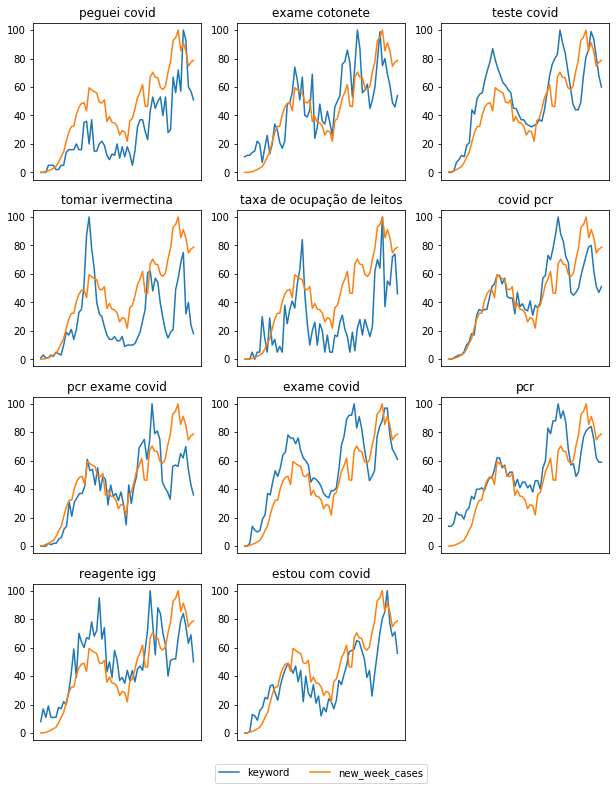

<Figure size 432x288 with 0 Axes>

In [62]:
facet_wrap(kwBR,brasilDf,'new_week_cases',lagcorr,kws,True)

In [63]:
def lagTable(kws,dfKW,dfInd,ind):
    result=pd.DataFrame()
    for i in kws:
        col=[]
        for j in range(6):
            if j==0:
                col.append(dfKW[:].reset_index()[i].corr(dfInd[:].reset_index()[ind],method='spearman'))
            else:
                col.append(dfKW[:-j].reset_index()[i].corr(dfInd[j:].reset_index()[ind],method='spearman'))
        result[i]=col
    return result

In [64]:
res=lagTable(kws,kwBR,brasilDf,'new_week_cases')
print('Tabela das lag correlations (keywords e novos casos)')
res

Tabela das lag correlations (keywords e novos casos)


,peguei covid,exame cotonete,teste covid,tomar ivermectina,taxa de ocupação de leitos,covid pcr,pcr exame covid,exame covid,pcr,reagente igg,estou com covid
0,0.868752,0.806117,0.692182,0.729825,0.741786,0.789447,0.726413,0.764302,0.829996,0.739691,0.850002
1,0.892912,0.829765,0.746558,0.746832,0.734635,0.820576,0.769529,0.808775,0.852000,0.745900,0.868204
2,0.906266,0.807622,0.783521,0.755959,0.712521,0.854592,0.792524,0.838354,0.875273,0.747077,0.871504
3,0.889282,0.786878,0.791272,0.755637,0.643257,0.850272,0.797482,0.825213,0.864969,0.734813,0.863190
4,0.865804,0.777770,0.774320,0.719043,0.563443,0.825636,0.765163,0.806904,0.823808,0.694722,0.829804
5,0.839389,0.737182,0.745107,0.676352,0.479492,0.805269,0.729525,0.769108,0.800031,0.632057,0.823736


In [65]:
kws=[]
for i in range(len(lagcorrd)):
    if(lagcorrd.iloc[i]['Lag']<=4) and lagcorrd.iloc[i]['MaxCorrelation']>=0.7:
        kws.append(lagcorr.iloc[i].name)
print('Tabela das lag correlations (keywords e novas mortes)')
res=lagTable(kws,kwBR,brasilDf,'new_week_deaths')
res

Tabela das lag correlations (keywords e novas mortes)


,peguei covid,sintomas do covid,teste covid,oximetro,oximetro de dedo,tomar ivermectina,covid,taxa de ocupação de leitos,exame covid,teste rápido covid,reagente igg,decreto lockdown,estou com covid
0,0.784887,0.458167,0.642223,0.608543,0.624849,0.718741,0.688217,0.747139,0.628214,0.534903,0.686564,0.743729,0.749856
1,0.816361,0.541860,0.697796,0.687078,0.698297,0.740945,0.746976,0.705310,0.666121,0.616616,0.715391,0.813891,0.785673
2,0.815073,0.632112,0.742971,0.738359,0.760385,0.759583,0.789292,0.695873,0.698712,0.668166,0.684759,0.843565,0.802925
3,0.804157,0.700253,0.767422,0.788202,0.782610,0.745490,0.809775,0.609071,0.701509,0.702121,0.668381,0.860029,0.823418
4,0.780426,0.754365,0.760258,0.806206,0.777021,0.718546,0.829267,0.571854,0.698167,0.697601,0.622806,0.847487,0.816065
5,0.746524,0.752663,0.734152,0.788379,0.767085,0.657823,0.819347,0.467892,0.669323,0.671735,0.557677,0.813636,0.791181


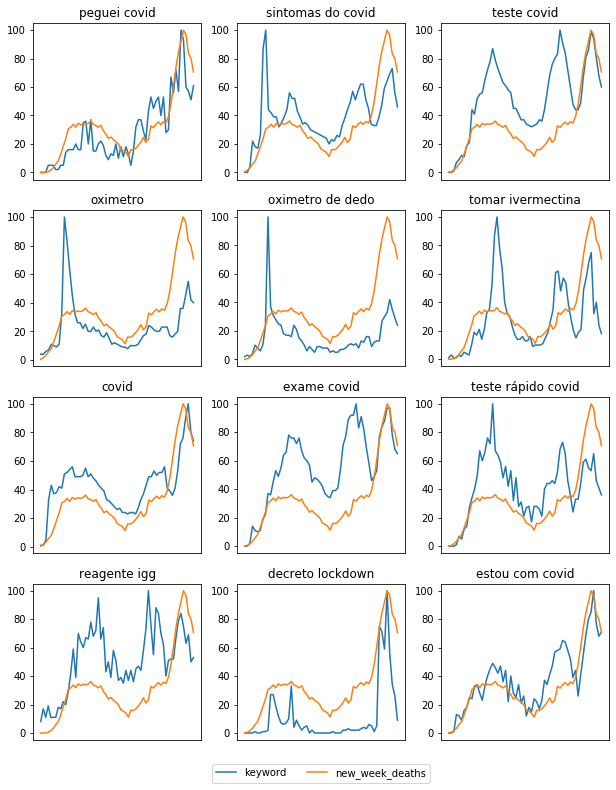

<Figure size 432x288 with 0 Axes>

In [66]:
kws.remove('taxa de ocupação de leitos')
facet_wrap(kwBR,brasilDf,'new_week_deaths',lagcorrd,kws)

In [67]:
kws

['peguei covid',
 'sintomas do covid',
 'teste covid',
 'oximetro',
 'oximetro de dedo',
 'tomar ivermectina',
 'covid',
 'exame covid',
 'teste rápido covid',
 'reagente igg',
 'decreto lockdown',
 'estou com covid']

In [ ]:
lagcorrd.sort_values(by='MaxCorrelation',ascending=False)[0:40]